In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import timedelta
import seaborn as sns
sns.set()

In [2]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
data = pd.read_csv('train_2.csv')

In [53]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [54]:
# we will fill NaN with 0 later

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


In [55]:
data_start_date = data.columns[1]
data_end_date = data.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2017-09-10


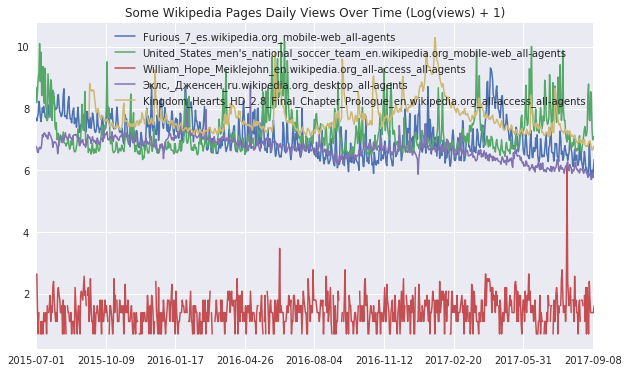

In [56]:
#Creating a function to visualize some random webpages
def plotting_random_series(data, n_series):
    
    sample = data.sample(n_series, random_state=6)
    page_labels = sample['Page'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))

    # for smoothing out the scale of traffic for different series , applying log1p transformation  
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Some Wikipedia Pages Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plotting_random_series(data, 5)

In [57]:
# applying exogenous feature engineering

#Converting dates to one-hot-encoded representations of day of the week
feature_one = pd.get_dummies(pd.to_datetime(data.columns[1:]).dayofweek)
feature_one.head(6)

,0,1,2,3,4,5,6
0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1
5,1,0,0,0,0,0,0


In [58]:
#converting into three dimensional array
feature_array = np.expand_dims(feature_one.values, axis=0)
feature_array = np.tile(feature_array,(data.shape[0],1,1))
feature_array.shape

(145063, 803, 7)

In [59]:
#adding page metadata to the array
data['Page'].head(6)

0              2NE1_zh.wikipedia.org_all-access_spider
1               2PM_zh.wikipedia.org_all-access_spider
2                3C_zh.wikipedia.org_all-access_spider
3           4minute_zh.wikipedia.org_all-access_spider
4    52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
5              5566_zh.wikipedia.org_all-access_spider
Name: Page, dtype: object

In [60]:
# exapanding name_project_access_agent from our data into multiple columns
page_data = data['Page'].str.rsplit('_', n=3, expand=True)
page_data.columns = ['name','project','access','agent']
page_data.head()

,name,project,access,agent
0,2NE1,zh.wikipedia.org,all-access,spider
1,2PM,zh.wikipedia.org,all-access,spider
2,3C,zh.wikipedia.org,all-access,spider
3,4minute,zh.wikipedia.org,all-access,spider
4,52_Hz_I_Love_You,zh.wikipedia.org,all-access,spider


In [61]:
page_data.nunique()

name       49174
project        9
access         3
agent          2
dtype: int64

In [62]:
#dropping the name and one-hot-encoding the low cardinality features 

page_data = page_data.drop('name', axis=1)

page_array = pd.get_dummies(page_data).values
page_array = np.expand_dims(page_array, axis=1) #converting into 3 dimensional array
page_array = np.tile(page_array,(1,feature_array.shape[1],1))
page_array.shape

(145063, 803, 14)

In [63]:
exogenous_array = np.concatenate([feature_array, page_array], axis=-1)
exogenous_array.shape

(145063, 803, 21)

In [64]:
#creating train_encoding, train_prediction, validation_encoding and validation_prediction period

prediction_period = 60 
prediction_length = timedelta(prediction_period)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

validation_prediction_start = last_day - prediction_length + timedelta(1)
validation_prediction_end = last_day

training_prediction_start = validation_prediction_start - prediction_length
training_prediction_end = validation_prediction_start - timedelta(days=1)

In [65]:
encoding_length = training_prediction_start - first_day

training_encoding_start = first_day
training_encoding_end = training_encoding_start + encoding_length - timedelta(1)

validation_encoding_start = training_encoding_start + prediction_length
validation_encoding_end = validation_encoding_start + encoding_length - timedelta(1)

In [66]:
print('Training encoding:', training_encoding_start, 'to', training_encoding_end)
print('Training prediction:', training_prediction_start, 'to', training_prediction_end, '\n')
print('Validation encoding:', validation_encoding_start, 'to', validation_encoding_end)
print('Val prediction:', validation_prediction_start, 'to', validation_prediction_end)

print('\nEncoding interval:', encoding_length.days)
print('Prediction interval:', prediction_length.days)

Training encoding: 2015-07-01 00:00:00 to 2017-05-13 00:00:00
Training prediction: 2017-05-14 00:00:00 to 2017-07-12 00:00:00 

Validation encoding: 2015-08-30 00:00:00 to 2017-07-12 00:00:00
Val prediction: 2017-07-13 00:00:00 to 2017-09-10 00:00:00

Encoding interval: 683
Prediction interval: 60


In [67]:
#data formatting

date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in data.columns[1:]]),
                          data=[i for i in range(len(data.columns[1:]))])
series_array = data[data.columns[1:]].values

# function to extract specified time interval from all the series

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

#function to tranfer all the series
def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1)) 
    # reshaping to the tensor format
    
    return series_array, series_mean

#extracting complete encoding and target arrays
def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [68]:
#creating a preprocessing function for extracting encoder and decoder data

def get_data_encode_decode(series_array, exogenous_array, first_n_samples,
                           date_to_index, encoding_start, encoding_end, 
                           prediction_start, prediction_end):

    exogenous_inds = date_to_index[encoding_start:prediction_end]
    
    # sample of series from encoding_start to encoding_end  
    encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                               encoding_start, encoding_end)[:first_n_samples]
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    # sample of series from prediction_start to prediction_end 
    decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                                prediction_start, prediction_end)[:first_n_samples]
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    # appending a lagged history of the target series to the input data 
    lagged_target_history = decoder_target_data[:,:-1,:1]
    encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)
    
    # adding the exogenous features
    exogenous_input_data = exogenous_array[:first_n_samples,exogenous_inds,:][:,1:,:]
    encoder_input_data = np.concatenate([encoder_input_data, exogenous_input_data], axis=-1)
    
    return encoder_input_data, decoder_target_data

In [24]:
# convolutional operation parameters
number_filters = 32 
filters_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# defining an input history series and passing it through a stack of dilated causal convolution blocks
history_series = Input(shape=(None, 1 + exogenous_array.shape[-1]))
y = history_series

skipped = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    y = Conv1D(32, 1, padding='same', activation='relu')(y) 
    
    # filter convolution
    filter_conv = Conv1D(filters=number_filters,
                 kernel_size=filters_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(y)
    
    # gating convolution
    gating_conv = Conv1D(filters=number_filters,
                 kernel_size=filters_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(y)
    
    # multiplying filter and gating branches
    filter_gating = Multiply()([Activation('tanh')(filter_conv),
                    Activation('sigmoid')(gating_conv)])
    
    # postprocessing - equivalent to time-distributed dense
    filter_gating = Conv1D(32, 1, padding='same', activation='relu')(filter_gating)
    
    # residual connection
    y = Add()([y, filter_gating])    
    
    # collecting skip connections
    skipped.append(filter_gating)

# adding all skip connection outputs 
output = Activation('relu')(Add()(skipped))

# final time-distributed dense layers 
output = Conv1D(128, 1, padding='same',activation = 'relu')(output)
output = Dropout(.2)(output)
output = Conv1D(1, 1, padding='same')(output)

# extracting the last 60 time steps as the training target
def slice(y, sequence_length):
    return y[:,-sequence_length:,:]

predict_sequence_train = Lambda(slice, arguments={'sequence_length':60})(output)

In [25]:
model = Model(history_series, predict_sequence_train)
model.compile(Adam(), loss='mean_absolute_error')

In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 22)     0                                            
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, None, 32)     736         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, None, 32)     2080        conv1d_67[0][0]                  
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, None, 32)     2080        conv1d_67[0][0]                  
____________________________________________________________________________________________

In [27]:
#training our model 
#Using AWS E2 instance with a GPU (p2.xlarge) and the Amazon Deep Learning AMI

first_n_samples = data.shape[0]
BATCH_SIZE = 2**10 
EPOCHS = 15

encoder_input_data, decoder_target_data = \
    get_data_encode_decode(series_array, exogenous_array, first_n_samples, date_to_index, 
                           training_encoding_start, training_encoding_end, 
                           training_prediction_start, training_prediction_end)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/15
145063/145063 [==============================] - 3745s 26ms/step - loss: 0.3458
Epoch 2/15
145063/145063 [==============================] - 3735s 26ms/step - loss: 0.2665
Epoch 3/15
145063/145063 [==============================] - 3744s 26ms/step - loss: 0.2598
Epoch 4/15
145063/145063 [==============================] - 3769s 26ms/step - loss: 0.2568
Epoch 5/15
145063/145063 [==============================] - 3770s 26ms/step - loss: 0.2555
Epoch 6/15
145063/145063 [==============================] - 3767s 26ms/step - loss: 0.2542
Epoch 7/15
145063/145063 [==============================] - 3780s 26ms/step - loss: 0.2533
Epoch 8/15
145063/145063 [==============================] - 3792s 26ms/step - loss: 0.2526
Epoch 9/15
145063/145063 [==============================] - 3778s 26ms/step - loss: 0.2519
Epoch 10/15
145063/145063 [==============================] - 3755s 26ms/step - loss: 0.2511
Epoch 11/15
145063/145063 [==============================] - 3755s 26ms/step - loss: 0.25

In [90]:
#Generating prediciton for the full interval we chose by doing 60 iterations 

def prediction_sequence(input_tensor):

    history_tensor = input_tensor[:,:(-prediction_period+1),:]
    pred_sequence = np.zeros((1,prediction_period,1)) # initialize output (pred_steps time steps)  
    
    for i in range(prediction_period):
        
        # recording next time step prediction
        last_step_prediction = model.predict(history_tensor)[0,-1,0]
        pred_sequence[0,i,0] = last_step_prediction
        
        # adding the next time step prediction along with corresponding exogenous features
        # to the history tensor
        last_step_exog = input_tensor[:,[(-prediction_period+1)+i],1:]
        last_step_tensor = np.concatenate([last_step_prediction.reshape((1,1,1)), 
                                           last_step_exog], axis=-1)
        history_tensor = np.concatenate([history_tensor, last_step_tensor], axis=1)

    return pred_sequence

#each iteration will extract the prediction for the time step one beyond our current history

In [79]:
# generating predictions
encoder_input_data, decoder_target_data = \
    get_data_encode_decode(series_array, exogenous_array, data.shape[0], date_to_index, 
                           validation_encoding_start, validation_encoding_end, 
                           validation_prediction_start, validation_prediction_end)

In [97]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, encoder_tail_len=50):

    encode_tensor = encoder_input_data[[sample_ind],:,:] 
    pred_series = prediction_sequence(encode_tensor)
    
    encode_series = encode_tensor[:,:(-prediction_period+1),0].reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-encoder_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+prediction_period),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+prediction_period),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoding Series with Tail of Length %d, Target Series, and Predictions' % encoder_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

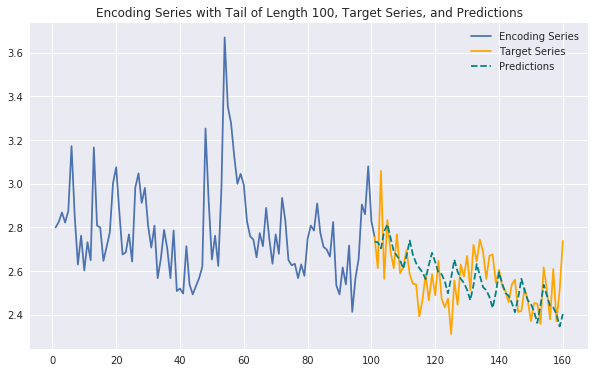

In [99]:
#plotting our future predictions
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=12323, encoder_tail_len=100)

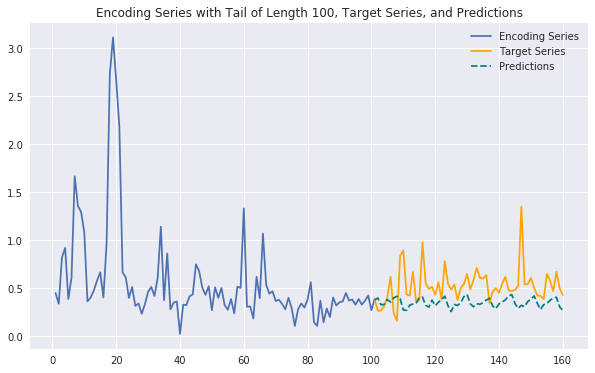

In [105]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=21123, encoder_tail_len=100)

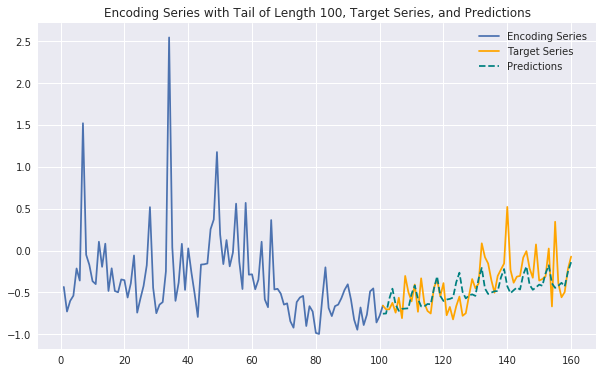

In [110]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=55000, encoder_tail_len=100)

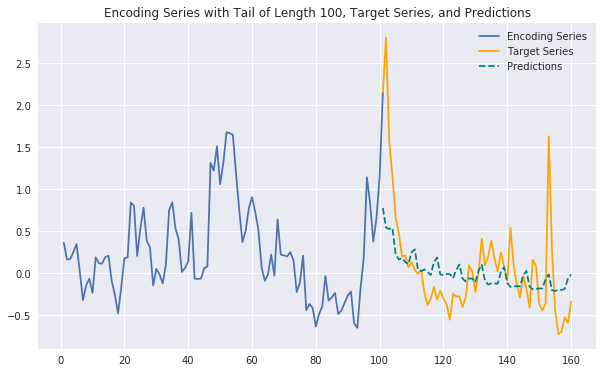

In [126]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=53674, encoder_tail_len=100)

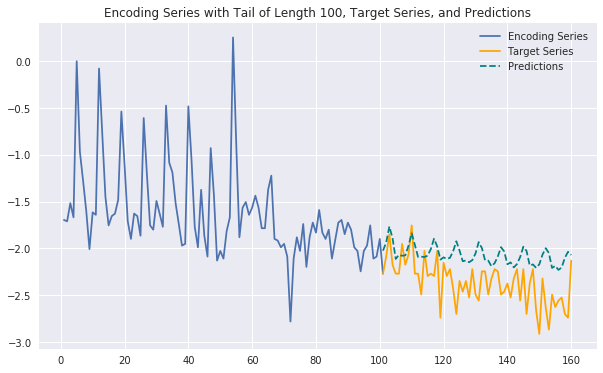

In [128]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=19363, encoder_tail_len=100)

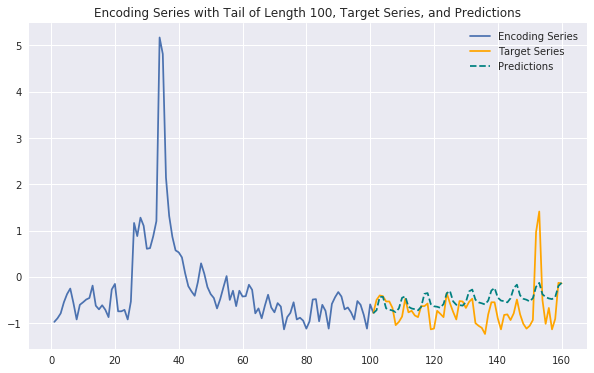

In [132]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=19394, encoder_tail_len=100)